# Notebook 1: Protocolo de Extracción de Datos y Preparación del Dataset (Sampling)
## Proyecto: Evaluación de Riesgo Arqueológico mediante Machine Learning
**Caso de Estudio:** Modelo Predictivo de Probabilidad de Hallazgos en el Territorio Peruano

**Autor:** Yishar Piero Nieto Barrientos  
**Repositorio de Investigación:** [Tu enlace de GitHub aquí]

---

### **Introducción**
Este notebook constituye la fase inicial del flujo de trabajo de **Ingeniería de Características (Feature Engineering)** aplicado a la arqueología preventiva[cite: 7]. El objetivo central es la transformación de datos geoespaciales continuos (Rasters) en una estructura de datos tabular (Dataframe) apta para algoritmos de aprendizaje supervisado[cite: 48, 58].

Mediante la técnica de **"Pixel Drilling"** o muestreo puntual multivariable, se extraen los valores de variables biofísicas y culturales en coordenadas específicas[cite: 50, 57]. Este proceso permite que el modelo identifique patrones de asentamiento basados en la habitabilidad y la proximidad a recursos estratégicos[cite: 19, 20].

### **Especificaciones Técnicas**
* **Resolución Espacial:** 30 x 30 metros por píxel, asegurando un balance entre precisión geográfica y eficiencia computacional.
* **Estrategia de Optimización:** Pre-cálculo de distancias euclidianas y variables derivadas en entorno GIS (Rasterización previa) para acelerar la inferencia en Python[cite: 4, 5, 6].
* **Variables Predictoras:** Topografía (Pendiente, Rugosidad), Hidrografía (Ríos, Lagos) y Redes Culturales (Qhapaq Ñan, Sitios Declarados)[cite: 21, 24, 28, 35, 39].

### **1. Instalacion de librerias**
Instalamos las librerías necesarias para el manejo de rasters y modelos predictivos.

In [16]:
import os
import sys
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio
import fiona
import seaborn as sns

from shapely.geometry import Point

# Esto es para que los mapas se vean bonitos dentro del notebook
%matplotlib inline

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


### **2. Inventario de Variables y Fuentes de Datos**
Para garantizar la validez del modelo predictivo, se han seleccionado variables que responden a criterios de habitabilidad, acceso a recursos y conectividad arqueológica. Cada capa ha sido procesada con una resolución de 30 metros.

| Categoría | Capa Raster (.tif) | Descripción Técnica | Justificación Arqueológica |
| :--- | :--- | :--- | :--- |
| **Topografía** | `pendiente_calca.tif` | Inclinación del terreno en grados. | Define áreas aptas para construcción y agricultura. |
| **Topografía** | `rugosidad_calca.tif` | Índice de Rugosidad del Terreno (TRI). | Identifica la complejidad del relieve y transitabilidad. |
| **Hidrografía**| `distancia_rios_calca.tif` | Distancia euclidiana a redes hídricas. | Recurso vital para el sustento y comunicación. |
| **Hidrografía**| `distancia_lagos_calca.tif` | Distancia a cuerpos hídricos lénticos. | Zonas de captación de recursos y posible carácter ritual. |
| **Cultura** | `distancia_qhapaq.tif` | Proximidad a la red vial incaica. | Eje de articulación territorial y hallazgos asociados |
| **Evidencia** | `distancia_declarados.tif` | Distancia a sitios arqueológicos registrados. | Probabilidad aumentada por recurrencia de ocupación. |

In [ ]:
# Lista de archivos basada en tu tabla de variables
archivos_raster = [
    '../data/processed/raster_pendiente.tif',
    '../data/processed/raster_rugosidad.tif',
    '../data/processed/distancia_lagos.tif',
    '../data/processed/distancia_rios.tif',
    '../data/processed/distancia_qhapaq.tif',
    '../data/processed/distancia_declarados.tif',
    '../data/processed/distancia_g1.tif',
    '../data/processed/distancia_g2.tif',
    '../data/processed/distancia_g3.tif'
]

print("--- Verificando Fuentes de Datos Geoespaciales ---")
for ruta in archivos_raster:
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # Validamos que la resolución sea de 30m como dice tu texto
            res_x, res_y = src.res
            print(f" {os.path.basename(ruta)} | Res: {res_x}m | CRS: {src.crs}")
    else:
        print(f"ADVERTENCIA: No se encontró el archivo en: {ruta}")

--- Verificando Fuentes de Datos Geoespaciales ---
 raster_pendiente.tif | Res: 30.0m | CRS: EPSG:32719
 raster_rugosidad.tif | Res: 30.0m | CRS: EPSG:32719
 distancia_lagos.tif | Res: 30.0m | CRS: EPSG:32719
 distancia_rios.tif | Res: 30.0m | CRS: EPSG:32719
 dis_qhapaq.tif | Res: 30.0m | CRS: EPSG:32719
 dis_declarados.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g1.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g2.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g3.tif | Res: 30.0m | CRS: EPSG:32719


#### **2.1 Visualizacion y validacion de capas topograficas**
Realizamos una carga ligera de cada variable para confirmar su integridad estructural y espacial antes del procesamiento masivo.

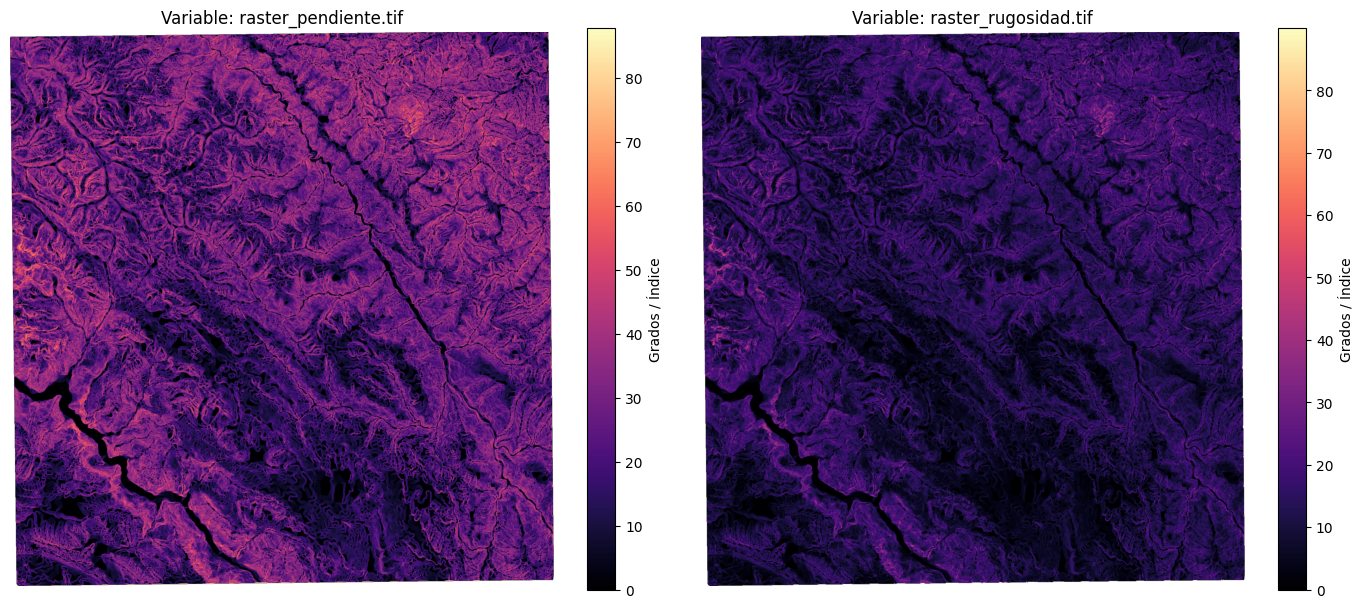

In [5]:
# Definimos las capas topográficas
capas_topografia = ['../data/processed/raster_pendiente.tif', '../data/processed/raster_rugosidad.tif']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ruta in enumerate(capas_topografia):
    with rasterio.open(ruta) as src:
        data = src.read(1)
        # Filtramos valores fuera de rango para recuperar el relieve
        data_filtrada = np.where((data < 0) | (data > 90), np.nan, data)
        
        im = axes[i].imshow(data_filtrada, cmap='magma')
        plt.colorbar(im, ax=axes[i], label='Grados / Índice')
        axes[i].set_title(f"Variable: {os.path.basename(ruta)}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

#### **2.2 Visualizacion y validacion de capas de distancia**
Se representan las distancias euclidianas hacia recursos hídricos y elementos culturales. El gradiente Viridis muestra la proximidad: los tonos oscuros indican cercanía inmediata, facilitando la identificación de zonas con mayor potencial de conectividad y recursos.

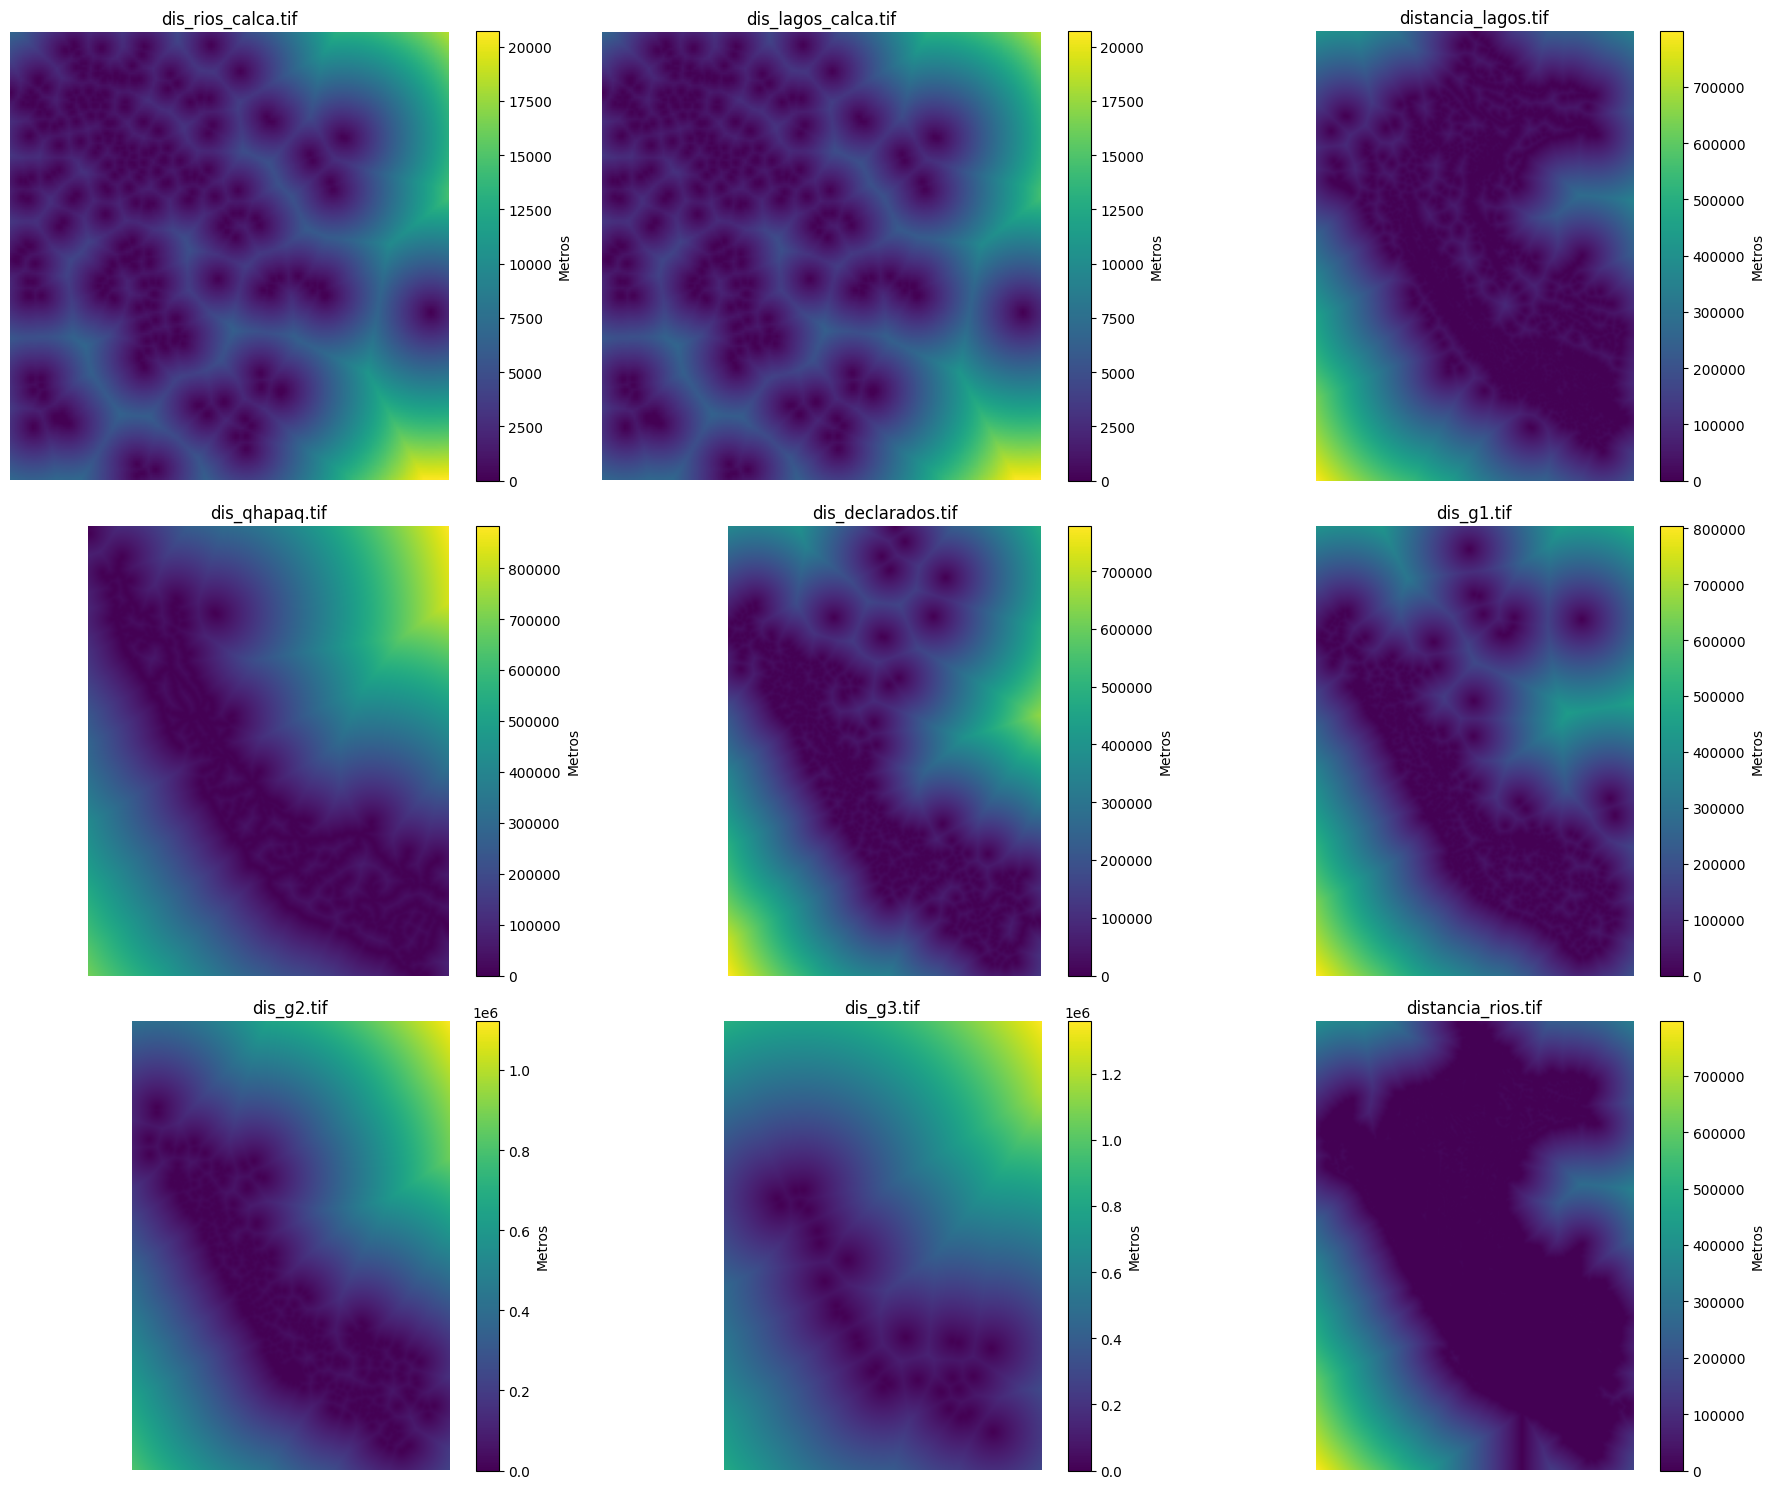

In [ ]:
# Lista actualizada con los 7 archivos
capas_distancia = [
    '../data/processed/distancia_rios_calca.tif', '../data/processed/distancia_lagos_calca.tif', '../data/processed/distancia_lagos.tif',
    '../data/processed/distancia_qhapaq.tif', '../data/processed/distancia_declarados.tif',
    '../data/processed/distancia_g1.tif', '../data/processed/distancia_g2.tif', '../data/processed/distancia_g3.tif',
    '../data/processed/distancia_rios.tif'
]

# Ajustamos a 3x3 para que quepan los 7 (sobrarán 2 espacios)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, ruta in enumerate(capas_distancia):
    with rasterio.open(ruta) as src:
        # Lectura al 10% para proteger la RAM de los 58GB
        data = src.read(1, out_shape=(1, int(src.height // 10), int(src.width // 10)))
        
        im = axes[i].imshow(data, cmap='viridis')
        plt.colorbar(im, ax=axes[i], label='Metros')
        axes[i].set_title(os.path.basename(ruta))
        axes[i].axis('off')

# Ocultamos los cuadros que sobraron (el 8 y el 9)
for j in range(len(capas_distancia), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **3. Preprocesamiento: Armonizacion de proyecciones CRS**

In [ ]:
#Pendiente

### **4. Analisis Exploratorio de datos (EDA)**
En esta etapa, transformamos los datos espaciales en datos estadísticos. Dado que manejamos un volumen de 58 GB, utilizaremos un muestreo aleatorio sistemático para obtener una representación estadísticamente significativa sin agotar los recursos de memoria RAM.

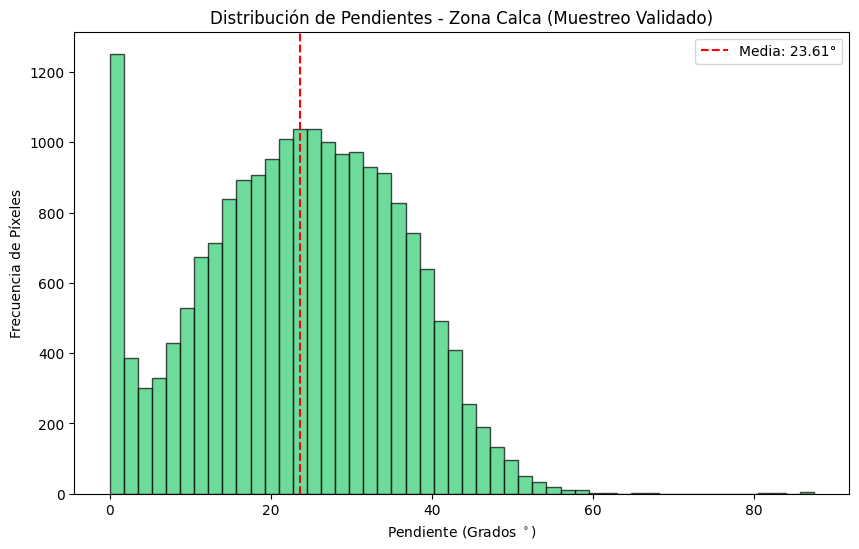

In [ ]:
ruta_pendiente = '../data/processed/raster_pendiente.tif'

def muestreo_inteligente(ruta, n_puntos=20000):
    with rasterio.open(ruta) as src:
        # Obtenemos los límites que acabamos de diagnosticar
        l, b, r, t = src.bounds
        muestras_validas = []
        
        # Intentamos capturar puntos hasta llenar nuestra cuota de n_puntos
        intentos = 0
        while len(muestras_validas) < n_puntos and intentos < n_puntos * 5:
            # Generamos coordenadas aleatorias REALES dentro de la extensión
            x_rand = np.random.uniform(l, r)
            y_rand = np.random.uniform(b, t)
            
            # Muestreamos el valor en esa coordenada geográfica
            for val in src.sample([(x_rand, y_rand)]):
                # Filtramos el NoData (-9999.0) y valores incoherentes
                if val[0] != -9999.0 and 0 <= val[0] <= 90:
                    muestras_validas.append(val[0])
            intentos += 1
            
        return muestras_validas

# Extraemos los datos con puntería láser
datos_pendiente = muestreo_inteligente(ruta_pendiente)

# Graficamos el Histograma Final
plt.figure(figsize=(10, 6))
# Usamos r'' para evitar el SyntaxWarning del \c
plt.hist(datos_pendiente, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)

media = np.mean(datos_pendiente)
plt.axvline(media, color='red', linestyle='dashed', label=f'Media: {media:.2f}°')

plt.title('Distribución de Pendientes - Zona Calca (Muestreo Validado)')
plt.xlabel(r'Pendiente (Grados $^\circ$)')
plt.ylabel('Frecuencia de Píxeles')
plt.legend()
plt.show()

Iniciando muestreo estratificado de 5000 píxeles...
Muestreo finalizado. Puntos válidos: 5000


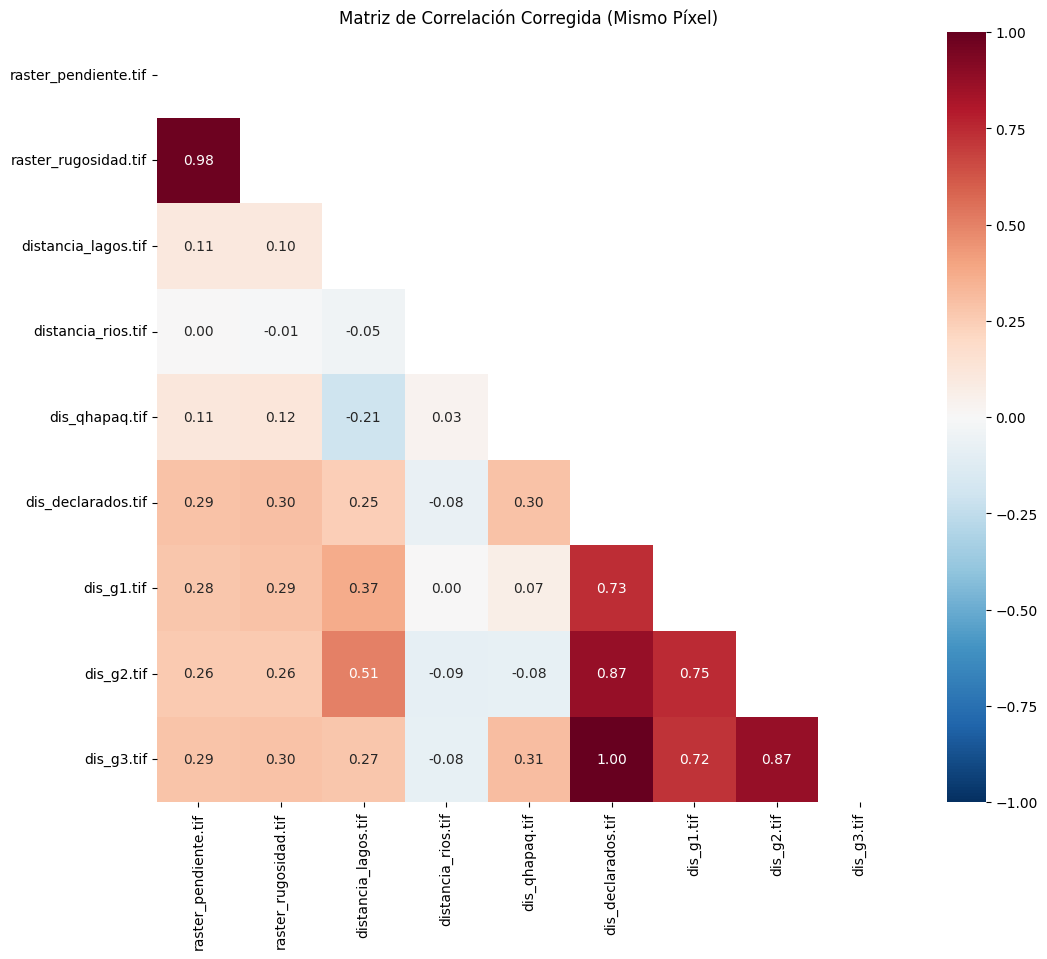

In [ ]:
# ==========================================
# CORRECCIÓN DE LA LÓGICA DE MUESTREO (STACK)
# ==========================================

def muestreo_multicapa(lista_rutas, n_puntos=10000):
    """
    Extrae valores de múltiples rasters en LAS MISMAS coordenadas.
    Esencial para análisis de correlación y entrenamiento de modelos.
    """
    data_matrix = []
    nombres_cols = [os.path.basename(r) for r in lista_rutas]
    
    # Abrimos todos los rasters a la vez
    src_files = [rasterio.open(r) for r in lista_rutas]
    
    # Usamos los límites del primer raster como referencia (el DEM)
    # Asumimos que todos están alineados (fase de pre-procesamiento)
    l, b, r, t = src_files[0].bounds
    
    puntos_recolectados = 0
    max_intentos = n_puntos * 50
    intentos = 0
    
    print(f"Iniciando muestreo estratificado de {n_puntos} píxeles...")
    
    while puntos_recolectados < n_puntos and intentos < max_intentos:
        # Generamos 1 coordenada aleatoria
        x_rand = np.random.uniform(l, r)
        y_rand = np.random.uniform(b, t)
        
        # Extraemos el valor de esa coordenada en TODAS las capas
        fila_valores = []
        valido = True
        
        for src in src_files:
            # sample devuelve un generador, tomamos el primer valor
            val = list(src.sample([(x_rand, y_rand)]))[0][0]
            
            # Validacion estricta: Si CUALQUIER capa tiene NoData, descartamos el punto entero
            # Ajusta -9999 si tus rasters de distancia usan otro valor de fondo
            if val == -9999.0 or np.isnan(val) or val < -1000: 
                valido = False
                break
            fila_valores.append(val)
            
        if valido:
            data_matrix.append(fila_valores)
            puntos_recolectados += 1
            
        intentos += 1

    # Cerramos los archivos
    for src in src_files:
        src.close()
        
    print(f"Muestreo finalizado. Puntos válidos: {len(data_matrix)}")
    return pd.DataFrame(data_matrix, columns=nombres_cols)

# --- EJECUCIÓN ---
# Generamos el dataset corregido
df_analisis = muestreo_multicapa(archivos_raster, n_puntos=5000)

# Verificamos la correlación de nuevo
plt.figure(figsize=(12, 10))
matriz_corr = df_analisis.corr()

# Máscara para ocultar la mitad superior repetida
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))

sns.heatmap(matriz_corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación Corregida (Mismo Píxel)')
plt.show()

### **5. Construcción de la Variable Dependiente (Target Variable)**

Para entrenar modelos de aprendizaje supervisado, se define una variable objetivo binaria ($Y$) que representa la probabilidad de ocurrencia de sitios arqueológicos.

#### **5.1 Procesamiento y Homogeneización de Presencias**

La evidencia arqueológica positiva ($Y=1$) proviene de dos fuentes vectoriales con geometrías distintas (Puntos y Polígonos). El procesamiento de estos datos sigue un protocolo estricto de alineación espacial y muestreo:

1.  **Estandarización del Sistema de Coordenadas (CRS):**
    Los datos originales se encuentran en el sistema geográfico WGS84 (EPSG:4326). Para garantizar la compatibilidad con las variables predictoras (Rasters) y permitir cálculos de distancia euclidiana precisos, se realiza una **reproyección vectorial** al sistema proyectado **UTM Zona 19S (EPSG:32719)**. Esto unifica la unidad de medida en metros.

2.  **Estrategia de Muestreo Estratificado (Mitigación de Sesgo):**
    Para evitar el sesgo por área (*Area Bias*) provocado por la disparidad de tamaños entre sitios:
    * **Sitios Puntuales (Declarados):** Se integran como observaciones únicas.
    * **Sitios Poligonales (Delimitados):** Se aplica un algoritmo de muestreo interno que genera puntos aleatorios proporcionales al área, con un **límite máximo (*Cap*) de 50 muestras** por sitio. Esto asegura que los grandes complejos no sobrerrepresenten la variabilidad ambiental en el dataset de entrenamiento.

--- 🚀 INICIANDO PROCESAMIENTO DE PRESENCIAS (V2 - SISTEMÁTICO) ---

1. Cargando Polígonos: delimitados.shp
   [TRANSFORMACIÓN] Reproyectando EPSG:4326 -> EPSG:32719...
  > Iniciando Muestreo Sistemático en 10665 polígonos...
   ✅ Polígonos procesados: 108280 puntos de muestreo generados.

2. Cargando Puntos Declarados: declarados.shp
   [TRANSFORMACIÓN] Reproyectando EPSG:4326 -> EPSG:32719...
   ✅ Puntos procesados: 5890 registros directos.

🎯 DATASET FINAL DE PRESENCIAS (Y=1)
   Total de Muestras: 114170
   CRS del Sistema:   EPSG:32719


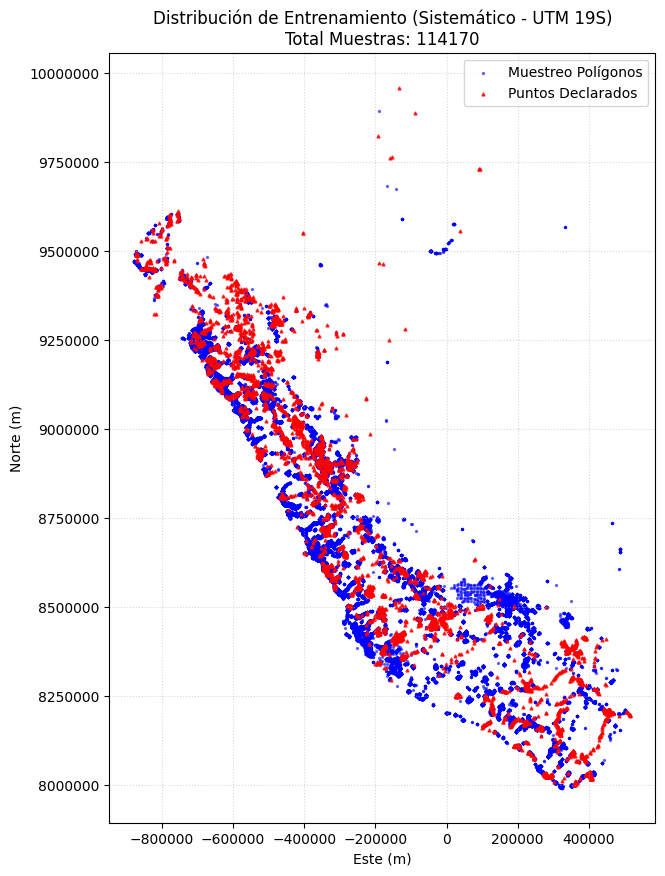

In [7]:
# ==========================================
# 1. CONFIGURACIÓN Y PARÁMETROS TÉCNICOS
# ==========================================
# CRS Objetivo: UTM Zona 19S (Metros) - Crucial para medir distancias reales
EPSG_OBJETIVO = 32719 

# Parámetros de Muestreo (Calibrados para resolución 30m)
AREA_PIXEL = 900              # 30m x 30m = 900 m²
DENSIDAD_MUESTREO = 10        # 1 punto cada 10 píxeles teóricos (balance entre carga y detalle)
MAX_PUNTOS_POR_POLIGONO = 60  # CAP aumentado ligeramente para aprovechar el barrido sistemático

# Rutas de Archivos (Ajusta a tu estructura de carpetas)
ruta_poligonos = '../data/raw/delimitados.shp'
ruta_puntos = '../data/raw/declarados.shp'

# ==========================================
# 2. FUNCIÓN DE MUESTREO SISTEMÁTICO (MEJORADA)
# ==========================================
def muestreo_sistematico_poligonos(gdf, max_puntos):
    """
    Genera puntos dentro de polígonos usando una grilla sistemática con 'jitter' (ruido aleatorio leve).
    Ventaja: Cubre espacialmente todo el sitio, evitando huecos vacíos típicos del random simple.
    """
    muestras = []
    print(f"  > Iniciando Muestreo Sistemático en {len(gdf)} polígonos...")
    
    for idx, row in gdf.iterrows():
        poly = row.geometry
        if poly is None or poly.is_empty: continue
        
        # A) Cálculo de puntos objetivo basado en área
        n_teorico = int(poly.area / (AREA_PIXEL * DENSIDAD_MUESTREO))
        # Forzamos al menos 1 punto, y respetamos el techo máximo
        n_target = max(1, min(n_teorico, max_puntos))
        
        # B) Cálculo del "Paso" (Stride) de la malla
        # Fórmula: Area ≈ n * stride^2  --> stride = sqrt(Area / n)
        stride = np.sqrt(poly.area / n_target)
        
        # C) Generación de la Malla (Barrido Geográfico)
        minx, miny, maxx, maxy = poly.bounds
        x_coords = np.arange(minx, maxx, stride)
        y_coords = np.arange(miny, maxy, stride)
        
        puntos_hit = []
        
        # D) Barrido e Inserción
        for x in x_coords:
            for y in y_coords:
                # E) Jitter: Desplazamiento aleatorio pequeño (±25% del paso)
                # Esto evita que los puntos se alineen artificialmente con los píxeles del raster
                offset_x = np.random.uniform(-stride/4, stride/4)
                offset_y = np.random.uniform(-stride/4, stride/4)
                
                pnt = Point(x + offset_x, y + offset_y)
                
                if poly.contains(pnt):
                    puntos_hit.append({
                        'geometry': pnt,
                        'origen': 'Poligono (Sistematico)',
                        'clase': 1,   # Presencia Arqueológica
                        'id_origen': idx # Rastreabilidad
                    })
                    
                # Break de seguridad por si la forma genera demasiados puntos
                if len(puntos_hit) >= max_puntos: break
            if len(puntos_hit) >= max_puntos: break
        
        # F) Fallback: Si la forma es muy irregular y la grilla falló, usar un punto central
        if len(puntos_hit) == 0:
            puntos_hit.append({
                'geometry': poly.representative_point(),
                'origen': 'Poligono (Centroide-Fallback)',
                'clase': 1,
                'id_origen': idx
            })
            
        muestras.extend(puntos_hit)
        
    return gpd.GeoDataFrame(muestras, crs=gdf.crs)

# ==========================================
# 3. FLUJO DE EJECUCIÓN (ETL)
# ==========================================
dataframes_list = []

print("--- 🚀 INICIANDO PROCESAMIENTO DE PRESENCIAS (V2 - SISTEMÁTICO) ---")

# ---------------------------------------------------------
# A) Procesar POLÍGONOS (Sitios Grandes)
# ---------------------------------------------------------
if os.path.exists(ruta_poligonos):
    print(f"\n1. Cargando Polígonos: {os.path.basename(ruta_poligonos)}")
    gdf_poly = gpd.read_file(ruta_poligonos)
    
    # Reproyección Obligatoria a Metros
    if gdf_poly.crs.to_string() != f"EPSG:{EPSG_OBJETIVO}":
        print(f"   [TRANSFORMACIÓN] Reproyectando {gdf_poly.crs} -> EPSG:{EPSG_OBJETIVO}...")
        gdf_poly = gdf_poly.to_crs(epsg=EPSG_OBJETIVO)
    
    # Aplicar la nueva función
    gdf_muestras = muestreo_sistematico_poligonos(gdf_poly, MAX_PUNTOS_POR_POLIGONO)
    dataframes_list.append(gdf_muestras)
    print(f"   ✅ Polígonos procesados: {len(gdf_muestras)} puntos de muestreo generados.")
else:
    print(f"❌ [ERROR] No se encontró el archivo: {ruta_poligonos}")

# ---------------------------------------------------------
# B) Procesar PUNTOS (Sitios Declarados Puntuales)
# ---------------------------------------------------------
if os.path.exists(ruta_puntos):
    print(f"\n2. Cargando Puntos Declarados: {os.path.basename(ruta_puntos)}")
    gdf_pts = gpd.read_file(ruta_puntos)
    
    # Reproyección Obligatoria
    if gdf_pts.crs.to_string() != f"EPSG:{EPSG_OBJETIVO}":
        print(f"   [TRANSFORMACIÓN] Reproyectando {gdf_pts.crs} -> EPSG:{EPSG_OBJETIVO}...")
        gdf_pts = gdf_pts.to_crs(epsg=EPSG_OBJETIVO)
        
    # Estandarizar estructura
    temp_pts = gdf_pts[['geometry']].copy()
    temp_pts['origen'] = 'Punto (Declarado)'
    temp_pts['clase'] = 1
    temp_pts['id_origen'] = temp_pts.index
    
    dataframes_list.append(temp_pts)
    print(f"   ✅ Puntos procesados: {len(temp_pts)} registros directos.")
else:
    print(f"❌ [ERROR] No se encontró el archivo: {ruta_puntos}")

# ==========================================
# 4. CONSOLIDACIÓN Y CONTROL DE CALIDAD
# ==========================================
if dataframes_list:
    gdf_presencias = pd.concat(dataframes_list, ignore_index=True)
    
    print("\n" + "="*60)
    print(f"🎯 DATASET FINAL DE PRESENCIAS (Y=1)")
    print(f"   Total de Muestras: {len(gdf_presencias)}")
    print(f"   CRS del Sistema:   EPSG:{gdf_presencias.crs.to_epsg()}")
    print("="*60)
    
    # Visualización de Control
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Graficar puntos diferenciando origen
    gdf_presencias[gdf_presencias['origen'].str.contains('Poligono')].plot(
        ax=ax, color='blue', markersize=2, alpha=0.5, label='Muestreo Polígonos'
    )
    gdf_presencias[gdf_presencias['origen'].str.contains('Punto')].plot(
        ax=ax, color='red', markersize=4, marker='^', alpha=0.8, label='Puntos Declarados'
    )
    
    plt.title(f"Distribución de Entrenamiento (Sistemático - UTM 19S)\nTotal Muestras: {len(gdf_presencias)}")
    plt.xlabel("Este (m)")
    plt.ylabel("Norte (m)")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.ticklabel_format(style='plain') 
    plt.show()

else:
    print("⚠️ No se generaron datos. Revisa las rutas de tus archivos.")

#### **5.2 Generación de Pseudo-Ausencias (Background Points)**

En el modelado de distribución de especies (SDM) y arqueología predictiva, los registros suelen ser de tipo "Solo-Presencia". Para entrenar clasificadores binarios como Random Forest, es indispensable generar una clase de contraste ($Y=0$) que represente la disponibilidad ambiental del territorio.

Se implementa la generación de **Pseudo-Ausencias** (*Pseudo-absences*) bajo un diseño experimental riguroso:

1.  **Espacio de Muestreo (UTM 19S):** Los puntos se generan aleatoriamente dentro de los límites definidos por las variables raster (área de estudio), asegurando que cada punto tenga valores ambientales válidos.
2.  **Criterio de Exclusión (Buffer):** Se aplica una restricción espacial de **500 metros** alrededor de todos los sitios arqueológicos confirmados (Presencias). Esto minimiza la probabilidad de "Falsos Negativos" (etiquetar como ausencia un área aledaña a un sitio que podría contener vestigios no excavados).
3.  **Balanceo de Clases (Ratio 1:1):** Se genera un número de ausencias equivalente al total de presencias ($n \approx 16,000$), garantizando un dataset balanceado que previene el sesgo del algoritmo hacia la clase mayoritaria.

🔍 Leyendo límites del archivo maestro: ../data/processed/curvas_unificadas_19s.gpkg...
✅ Límites detectados (UTM): (-877659.760880274, 7973812.12784252, 534408.063092074, 9995235.08991743)
📐 Dimensiones del Lienzo: 1412.1 km x 2021.4 km

⚙️ Generando malla para 114170 ausencias...
   > Espaciamiento de grilla: 4385.39 metros
   > Candidatos brutos: 148442
   > Eliminando puntos sobre sitios arqueológicos (Buffer)...

✅ DATASET DE ENTRENAMIENTO GENERADO
   Presencias: 114170
   Ausencias:  114170 (Distribuidas en el área de curvas)


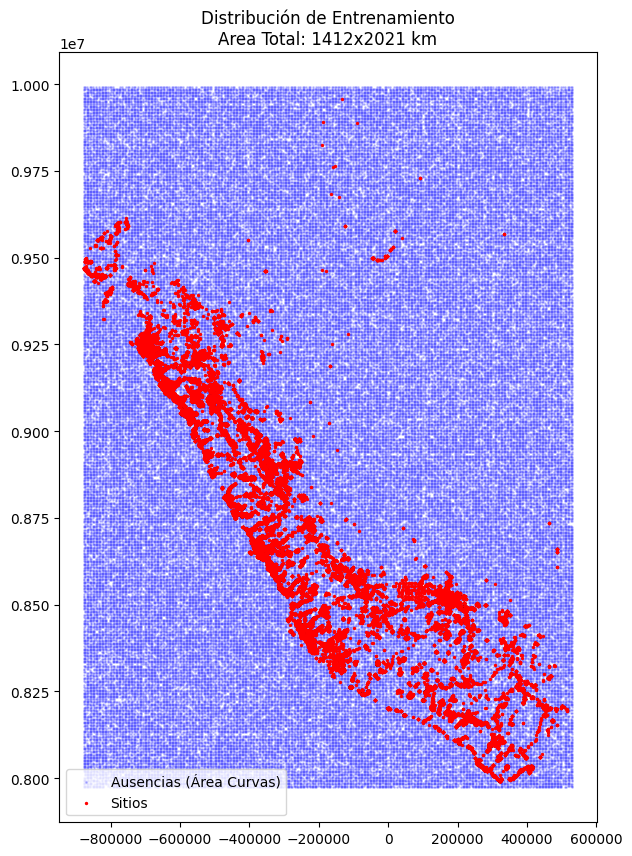

In [8]:
# ==========================================
# 1. PARÁMETROS
# ==========================================
BUFFER_SEGURIDAD = 500  # Metros alrededor de sitios (Zona Prohibida)
RATIO_AUSENCIAS = 1.0   # 1:1
OVERSAMPLING = 1.3      # Generamos 30% extra para filtrar después

# Ruta a tu archivo VECTORIAL original (las curvas sin procesar)
# Este archivo define "El Mundo Conocido" para tu modelo
ruta_curvas_gpkg = '../data/processed/curvas_unificadas_19s.gpkg' 

# ==========================================
# 2. OBTENER LÍMITES DEL MAPA DE CURVAS (¡Sin cargar todo!)
# ==========================================
print(f"🔍 Leyendo límites del archivo maestro: {ruta_curvas_gpkg}...")

try:
    # Usamos fiona para leer solo el encabezado (Metadata) -> Es instantáneo
    with fiona.open(ruta_curvas_gpkg, 'r') as src:
        bounds = src.bounds # (minx, miny, maxx, maxy)
        crs_origen = src.crs
        
    print(f"✅ Límites detectados (UTM): {bounds}")
    
    # Calcular Área Total
    minx, miny, maxx, maxy = bounds
    ancho = maxx - minx
    alto = maxy - miny
    area_total = ancho * alto
    print(f"📐 Dimensiones del Lienzo: {ancho/1000:.1f} km x {alto/1000:.1f} km")

except Exception as e:
    print(f"❌ Error leyendo el GPKG: {e}")
    # Fallback de emergencia (solo si falla el archivo)
    bounds = gdf_presencias.total_bounds
    area_total = (bounds[2]-bounds[0]) * (bounds[3]-bounds[1])

# ==========================================
# 3. GENERADOR DE GRILLA (Adaptado al Mapa de Curvas)
# ==========================================
def generar_ausencias_en_curvas(n_target, area_bounds, gdf_prohibido, buffer_dist):
    print(f"\n⚙️ Generando malla para {n_target} ausencias...")
    
    # 1. Calcular Stride (Paso)
    # Ahora 'area_total' es gigante, así que el stride será un número normal (ej. 500m, 1000m)
    n_bruto = int(n_target * OVERSAMPLING)
    if n_bruto == 0: n_bruto = 1
    
    stride = np.sqrt(area_total / n_bruto)
    print(f"   > Espaciamiento de grilla: {stride:.2f} metros")
    
    # 2. Generar Coordenadas
    min_x, min_y, max_x, max_y = area_bounds
    x_coords = np.arange(min_x, max_x, stride)
    y_coords = np.arange(min_y, max_y, stride)
    
    if len(x_coords) * len(y_coords) > 5000000:
        print("⚠️ [AVISO] El área es muy grande, se generarán muchos puntos candidatos.")

    # 3. Crear Puntos
    xx, yy = np.meshgrid(x_coords, y_coords)
    puntos = [Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())]
    
    gdf_candidatos = gpd.GeoDataFrame(geometry=puntos, crs=gdf_prohibido.crs)
    print(f"   > Candidatos brutos: {len(gdf_candidatos)}")

    # 4. LIMPIEZA: Eliminar puntos que caen ENCIMA de sitios arqueológicos
    print("   > Eliminando puntos sobre sitios arqueológicos (Buffer)...")
    
    # Crear zona prohibida
    gdf_buffer = gdf_prohibido.copy()
    gdf_buffer.geometry = gdf_buffer.geometry.buffer(buffer_dist)
    
    # Filtrado espacial (Spatial Join - Inner = Intersección)
    # Buscamos los que CHOCAN para eliminarlos
    conflictos = gpd.sjoin(gdf_candidatos, gdf_buffer, how='inner', predicate='intersects')
    
    # Nos quedamos con los que NO están en la lista de conflictos
    indices_seguros = ~gdf_candidatos.index.isin(conflictos.index)
    gdf_seguros = gdf_candidatos[indices_seguros].copy()
    
    # 5. Muestreo Final (Downsampling)
    # Si tenemos más de los necesarios, elegimos aleatoriamente para romper el patrón de grilla perfecto
    if len(gdf_seguros) > n_target:
        gdf_seguros = gdf_seguros.sample(n_target, random_state=42)
        
    gdf_seguros['clase'] = 0
    gdf_seguros['origen'] = 'Ausencia (Fondo)'
    
    return gdf_seguros

# ==========================================
# 4. EJECUCIÓN
# ==========================================
n_presencias = len(gdf_presencias)
n_requeridos = int(n_presencias * RATIO_AUSENCIAS)

# Ejecutar usando los bounds del GPKG
gdf_ausencias = generar_ausencias_en_curvas(
    n_requeridos, 
    bounds, 
    gdf_presencias, 
    BUFFER_SEGURIDAD
)

# Unir Datasets
gdf_final_train = pd.concat([gdf_presencias, gdf_ausencias], ignore_index=True)

# ==========================================
# 5. VALIDACIÓN VISUAL
# ==========================================
print("\n" + "="*50)
print(f"✅ DATASET DE ENTRENAMIENTO GENERADO")
print(f"   Presencias: {len(gdf_presencias)}")
print(f"   Ausencias:  {len(gdf_ausencias)} (Distribuidas en el área de curvas)")
print("="*50)

# Gráfico rápido
fig, ax = plt.subplots(figsize=(10, 10))
gdf_ausencias.plot(ax=ax, color='blue', markersize=1, alpha=0.2, label='Ausencias (Área Curvas)')
gdf_presencias.plot(ax=ax, color='red', markersize=2, label='Sitios')
plt.legend()
plt.title(f"Distribución de Entrenamiento\nArea Total: {ancho/1000:.0f}x{alto/1000:.0f} km")
plt.show()

#### **5.3 Extracción de variable (Pixel Drilling)**

In [ ]:
# 1. CONFIGURACIÓN DEL "MENÚ" DE VARIABLES
# ---------------------------------------------------------------------
# Lista aquí TODAS las variables que tendrá tu modelo final.
# El script verificará automáticamente cuáles existen y cuáles no.
# ---------------------------------------------------------------------
mis_rasters = {
    # --- VARIABLES TOPOGRÁFICAS (Faltantes / En proceso) ---
    'pendiente': '../data/processed/raster_slope.tif',         
    'rugosidad': '../data/processed/raster_tri.tif',           
    
    # --- VARIABLES DE DISTANCIA (Disponibles ahora) ---
    # Ajusta los nombres de archivo si los tuyos son diferentes
    'dist_rios':       '../data/processed/distancia_rios.tif',
    'dist_vias':       '../data/processed/distancia_vias.tif',
    'dist_sitios':     '../data/processed/distancia_sitios.tif',
    'dist_qhapaq':     '../data/processed/distancia_qhapaq.tif'
}

def extraer_valores_raster(gdf, dict_rasters):
    """
    Función robusta de extracción.
    Verifica existencia de archivos y maneja errores de lectura.
    """
    gdf_copy = gdf.copy()
    # Convertimos geometría a lista de tuplas (x, y) para rasterio
    coord_list = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
    
    print(f"⛏️ Iniciando extracción de datos para {len(gdf)} puntos...")
    vars_extraidas = []
    
    for nombre_var, ruta_tif in dict_rasters.items():
        # A) VALIDACIÓN DE EXISTENCIA
        if not os.path.exists(ruta_tif):
            print(f"   ⚠️ [SALTANDO] No se encontró el archivo: {ruta_tif}")
            # Rellenamos con NaN para mantener la columna (opcional, ayuda al merge futuro)
            # gdf_copy[nombre_var] = np.nan 
            continue
            
        # B) EXTRACCIÓN (DRILLING)
        print(f"   > Perforando capa: {nombre_var}...")
        try:
            with rasterio.open(ruta_tif) as src:
                # sample() devuelve un generador. Usamos [0] para sacar el valor de la banda 1.
                valores = [x[0] for x in src.sample(coord_list)]
                gdf_copy[nombre_var] = valores
                vars_extraidas.append(nombre_var)
        except Exception as e:
            print(f"   ❌ Error crítico leyendo {nombre_var}: {e}")

    print(f"\n✅ Proceso completado. Variables agregadas: {vars_extraidas}")
    if len(vars_extraidas) == 0:
        print("⚠️ ADVERTENCIA: No se extrajo ninguna variable. Revisa tus rutas.")
        
    return gdf_copy

# 2. EJECUCIÓN DEL PROCESO
gdf_dataset_final = extraer_valores_raster(gdf_final_train, mis_rasters)

# ==========================================
# 6. LIMPIEZA Y EXPORTACIÓN (ETAPA FINAL)
# ==========================================

# A) Limpieza de Valores Nulos / NoData
# Solo limpiamos basándonos en las columnas que SÍ se extrajeron
cols_presentes = [col for col in mis_rasters.keys() if col in gdf_dataset_final.columns]

if cols_presentes:
    print(f"\n🧹 Iniciando limpieza en columnas: {cols_presentes}")
    n_inicial = len(gdf_dataset_final)
    
    # Reemplazar valores de error típicos de GIS (-9999, valores infinitos negativos)
    # Nota: A veces el NoData es -3.4028235e+38 en Float32
    for col in cols_presentes:
        gdf_dataset_final[col] = gdf_dataset_final[col].replace([-9999, -3.4028235e+38], np.nan)
    
    # Eliminar filas que tengan AL MENOS UN valor nulo en las variables
    # (Porque XGBoost prefiere datos limpios, aunque aguanta nulos, es mejor limpiar el entrenamiento)
    gdf_dataset_final = gdf_dataset_final.dropna(subset=cols_presentes)
    
    n_final = len(gdf_dataset_final)
    eliminados = n_inicial - n_final
    print(f"   > Filas eliminadas (fuera de rasters o NoData): {eliminados}")
    print(f"   > Dataset Final Válido: {n_final} muestras.")

# B) Exportación a CSV (Formato universal para ML)
ruta_salida_csv = '../data/processed/dataset_entrenamiento_v1.csv'

# Convertimos a DataFrame simple (sin geometría pesada)
# Guardamos X e Y por si queremos visualizar luego, pero NO para entrenar
df_export = pd.DataFrame(gdf_dataset_final.drop(columns='geometry'))
df_export['este_x'] = gdf_dataset_final.geometry.x
df_export['norte_y'] = gdf_dataset_final.geometry.y

# Reordenar columnas para que 'clase' quede al final o principio (estético)
cols = [c for c in df_export.columns if c not in ['clase']]
df_export = df_export[['clase'] + cols]

df_export.to_csv(ruta_salida_csv, index=False)

print("\n" + "="*50)
print(f"🎉 ¡NOTEBOOK 01 FINALIZADO!")
print(f"📂 Archivo generado: {os.path.abspath(ruta_salida_csv)}")
print(f"📊 Estructura: {df_export.shape} (Filas, Columnas)")
print("="*50)

⛏️ Iniciando extracción de datos para 228340 puntos...
   > Perforando capa: elevacion...
   ❌ Error crítico leyendo elevacion: '../data/processed/raster_dem_30m.tif' not recognized as being in a supported file format.
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/raster_slope.tif
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/raster_tri.tif
   > Perforando capa: dist_rios...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/distancia_vias.tif
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/distancia_sitios.tif
   > Perforando capa: dist_qhapaq...

✅ Proceso completado. Variables agregadas: ['dist_rios', 'dist_qhapaq']

🧹 Iniciando limpieza en columnas: ['dist_rios', 'dist_qhapaq']
   > Filas eliminadas (fuera de rasters o NoData): 0
   > Dataset Final Válido: 228340 muestras.

🎉 ¡NOTEBOOK 01 FINALIZADO!
📂 Archivo generado: /home/mazapan/Documentos/arqueologia-predictiva/data/processed/dataset_entrenamiento_v1.csv
📊 Estructura: (228340, 7) (Filas, Columnas)


### **6. Extracción de valores (Drilling)**
Perforar los mapas disponibles

In [12]:
# 1. CONFIGURACIÓN DEL "MENÚ" DE VARIABLES
# ---------------------------------------------------------------------
# Lista aquí TODAS las variables. El script detectará cuáles existen.
# Si el DEM aún se está procesando, el script lo saltará automáticamente.
# ---------------------------------------------------------------------
mis_rasters = {
    # --- VARIABLES TOPOGRÁFICAS (En proceso en la otra PC) ---
    'elevacion': '../data/processed/raster_dem_30m.tif',       
    'pendiente': '../data/processed/raster_slope.tif',         
    'rugosidad': '../data/processed/raster_tri.tif',           
    
    # --- VARIABLES DE DISTANCIA (Disponibles ahora) ---
    'dist_rios':       '../data/processed/distancia_rios.tif',
    'dist_lagoss':       '../data/processed/distancia_lagos.tif',
    'dist_qhapaq':     '../data/processed/distancia_qhapaq.tif',
    'dist_declaradps':     '../data/processed/distancia_declarados.tif',
    'dist_g1':     '../data/processed/distancia_g1.tif',
    'dist_g2':     '../data/processed/distancia_g2.tif',
    'dist_g3':     '../data/processed/g1.tif'
}

def extraer_valores_raster(gdf, dict_rasters):
    """
    Función robusta de extracción.
    Verifica existencia de archivos y maneja errores de lectura.
    """
    gdf_copy = gdf.copy()
    # Convertimos geometría a lista de tuplas (x, y) para rasterio
    coord_list = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
    
    print(f"⛏️ Iniciando extracción de datos para {len(gdf)} puntos...")
    vars_extraidas = []
    
    for nombre_var, ruta_tif in dict_rasters.items():
        # A) VALIDACIÓN DE EXISTENCIA
        if not os.path.exists(ruta_tif):
            print(f"   ⚠️ [SALTANDO] No se encontró el archivo: {ruta_tif}")
            continue
            
        # B) EXTRACCIÓN (DRILLING)
        print(f"   > Perforando capa: {nombre_var}...")
        try:
            with rasterio.open(ruta_tif) as src:
                # sample() devuelve un generador. Usamos [0] para sacar el valor de la banda 1.
                valores = [x[0] for x in src.sample(coord_list)]
                gdf_copy[nombre_var] = valores
                vars_extraidas.append(nombre_var)
        except Exception as e:
            print(f"   ❌ Error crítico leyendo {nombre_var}: {e}")

    print(f"\n✅ Proceso completado. Variables agregadas: {vars_extraidas}")
    
    if len(vars_extraidas) == 0:
        print("⚠️ ADVERTENCIA: No se extrajo ninguna variable raster (Solo tendrás geometría).")
        
    return gdf_copy

# 2. EJECUCIÓN DEL PROCESO
gdf_dataset_final = extraer_valores_raster(gdf_final_train, mis_rasters)

# ==========================================
# 6. LIMPIEZA Y EXPORTACIÓN (ETAPA FINAL)
# ==========================================

# A) Limpieza de Valores Nulos / NoData
cols_presentes = [col for col in mis_rasters.keys() if col in gdf_dataset_final.columns]

if cols_presentes:
    print(f"\n🧹 Iniciando limpieza en columnas: {cols_presentes}")
    n_inicial = len(gdf_dataset_final)
    
    # Reemplazar valores de error típicos de GIS (-9999, valores infinitos negativos)
    # Nota: A veces el NoData es -3.4028235e+38 en Float32
    for col in cols_presentes:
        gdf_dataset_final[col] = gdf_dataset_final[col].replace([-9999, -3.4028235e+38], np.nan)
    
    # Eliminar filas que tengan AL MENOS UN valor nulo en las variables extraídas
    gdf_dataset_final = gdf_dataset_final.dropna(subset=cols_presentes)
    
    n_final = len(gdf_dataset_final)
    eliminados = n_inicial - n_final
    print(f"   > Filas eliminadas (fuera de rasters o NoData): {eliminados}")
    print(f"   > Dataset Final Válido: {n_final} muestras.")

# B) Exportación a CSV
# Ruta solicitada por el usuario
ruta_salida = '../results/dataset_entrenamiento_final.csv'

# Convertimos a DataFrame simple
# Guardamos X e Y explícitamente (útil para visualización, NO para entrenar)
df_export = pd.DataFrame(gdf_dataset_final.drop(columns='geometry'))
df_export['este_x'] = gdf_dataset_final.geometry.x
df_export['norte_y'] = gdf_dataset_final.geometry.y

# Reordenar columnas: Clase primero, luego variables, luego coordenadas, luego metadatos
cols_ordenadas = ['clase'] + \
                 [c for c in cols_presentes] + \
                 ['este_x', 'norte_y'] + \
                 [c for c in df_export.columns if c not in ['clase', 'este_x', 'norte_y'] + cols_presentes]

df_export = df_export[cols_ordenadas]

# Asegurar que el directorio existe
os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)

df_export.to_csv(ruta_salida, index=False)

print("\n" + "="*50)
print(f"🎉 ¡NOTEBOOK 01 FINALIZADO!")
print(f"📂 Archivo generado: {os.path.abspath(ruta_salida)}")
print(f"📊 Estructura: {df_export.shape} (Filas, Columnas)")
print("="*50)

⛏️ Iniciando extracción de datos para 228340 puntos...
   > Perforando capa: elevacion...
   ❌ Error crítico leyendo elevacion: '../data/processed/raster_dem_30m.tif' not recognized as being in a supported file format.
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/raster_slope.tif
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/raster_tri.tif
   > Perforando capa: dist_rios...


/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype=np.int32)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/rasterio/transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype=np.int32)


   > Perforando capa: dist_lagoss...
   > Perforando capa: dist_qhapaq...
   > Perforando capa: dist_declaradps...
   > Perforando capa: dist_g1...
   > Perforando capa: dist_g2...
   ⚠️ [SALTANDO] No se encontró el archivo: ../data/processed/g1.tif

✅ Proceso completado. Variables agregadas: ['dist_rios', 'dist_lagoss', 'dist_qhapaq', 'dist_declaradps', 'dist_g1', 'dist_g2']

🧹 Iniciando limpieza en columnas: ['dist_rios', 'dist_lagoss', 'dist_qhapaq', 'dist_declaradps', 'dist_g1', 'dist_g2']
   > Filas eliminadas (fuera de rasters o NoData): 0
   > Dataset Final Válido: 228340 muestras.

🎉 ¡NOTEBOOK 01 FINALIZADO!
📂 Archivo generado: /home/mazapan/Documentos/arqueologia-predictiva/results/dataset_entrenamiento_final.csv
📊 Estructura: (228340, 11) (Filas, Columnas)


## 6. Validación Espacial
**Propósito:** Validar estadísticamente la calidad del muestreo y la capacidad discriminante de las variables antes del modelado. 
Esta sección genera las evidencias visuales requeridas para la publicación (Figuras 1, 2 y 3), asegurando que:
1. Las pseudo-ausencias cubren efectivamente el área de estudio.
2. Existe una diferenciación física medible entre sitios arqueológicos y el entorno aleatorio.

📊 Variables numéricas detectadas: ['dist_rios', 'dist_lagoss', 'dist_qhapaq', 'dist_declaradps', 'dist_g1', 'dist_g2']
🌎 Total de puntos a graficar: 228340
   > Rango X (Este): -877685.9 a inf
   > Rango Y (Norte): 7973812.1 a inf
Generando Fig 1: Mapa de Distribución Completo...


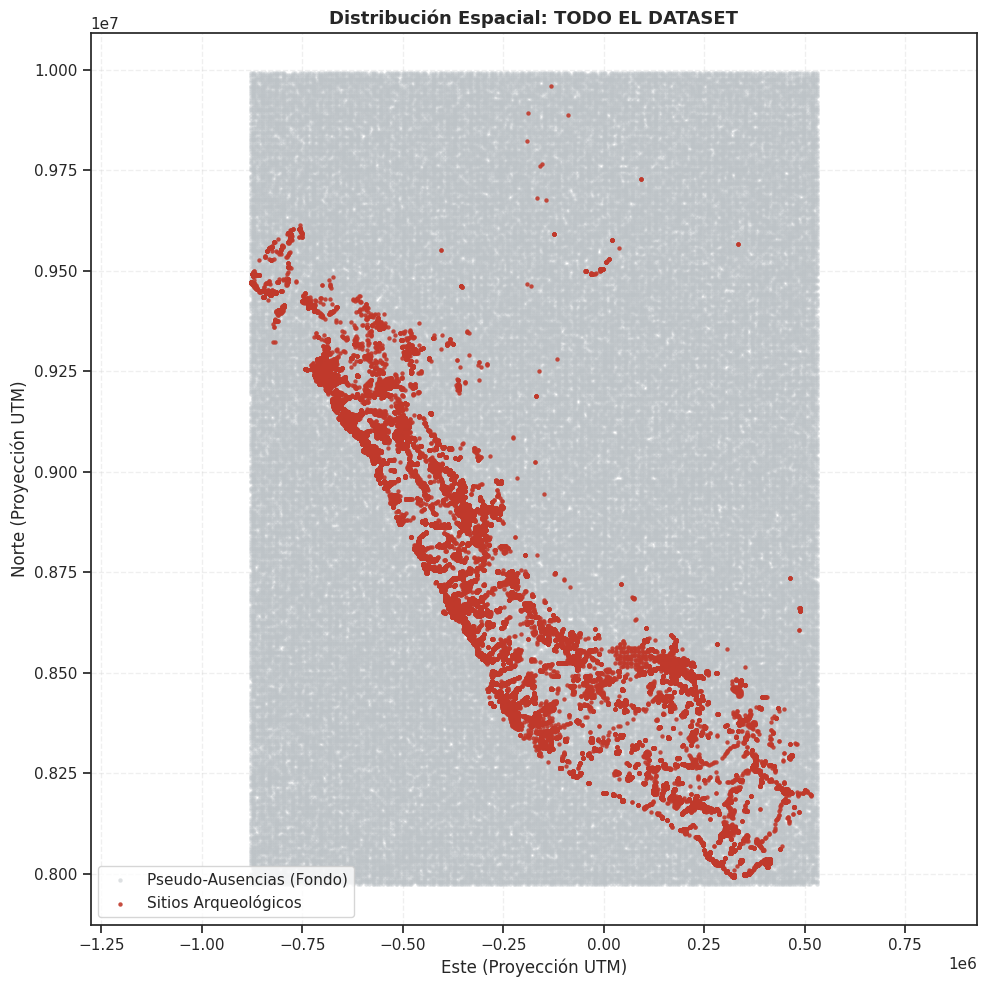

Generando Fig 2: Boxplots Comparativos...


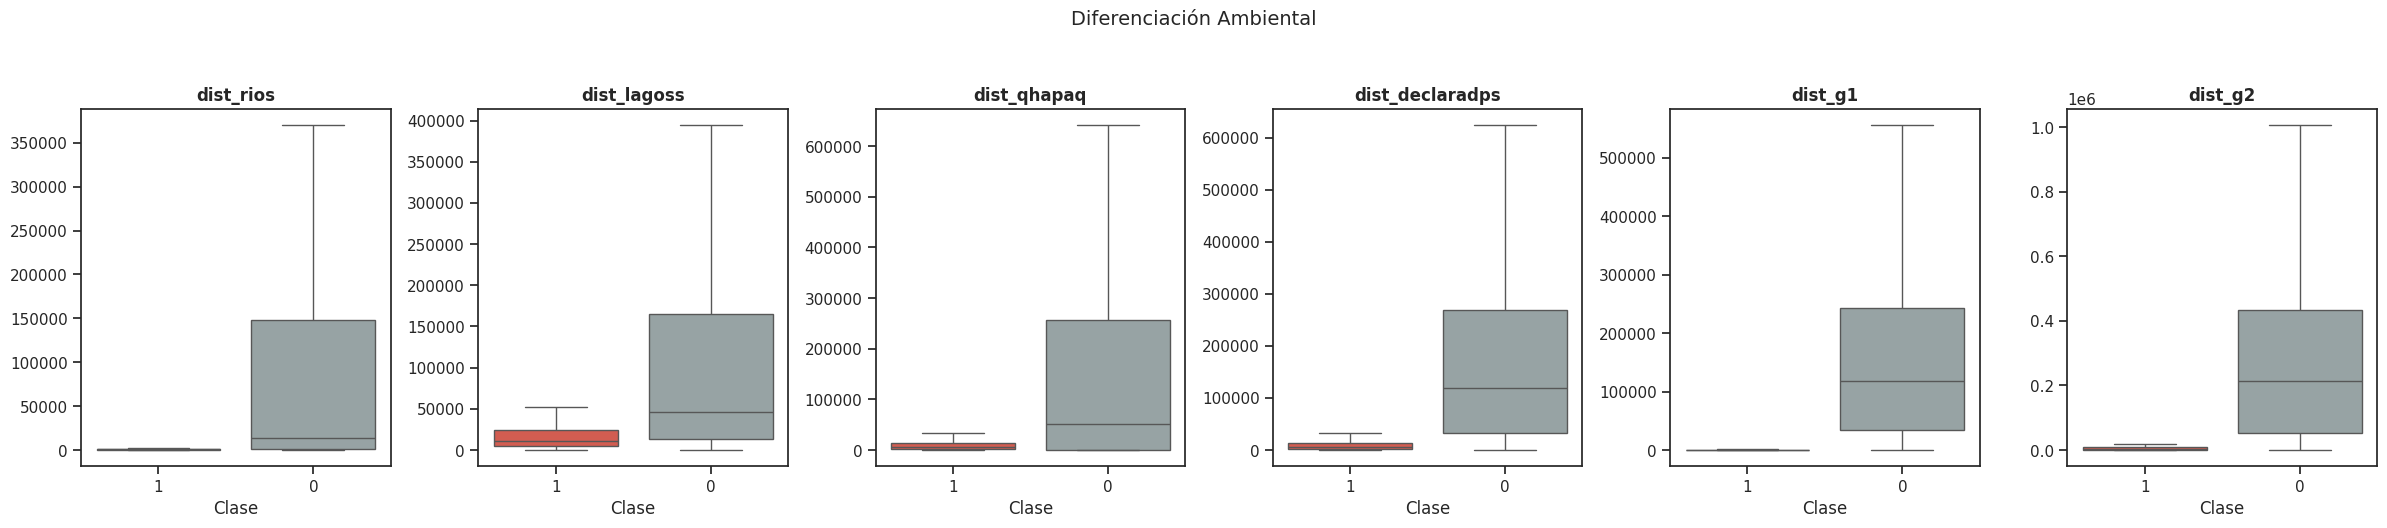

Generando Fig 3: Matriz de Correlación...


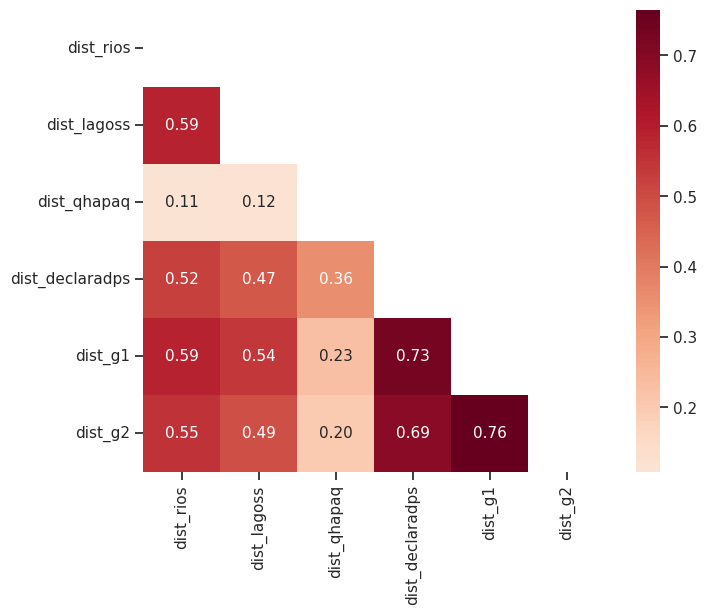

In [22]:
# 1. Cargar datos
ruta_csv = '../results/dataset_entrenamiento_final.csv' # Verifica que esta ruta sea la correcta
df = pd.read_csv(ruta_csv)

# --- CORRECCIÓN DE TIPOS ---
df['clase'] = df['clase'].astype(str)

# Filtramos columnas que no sirven para análisis estadístico
cols_ignorar = ['este_x', 'norte_y', 'clase', 'id_origen', 'origen', 'Unnamed: 0']
cols_analisis = [c for c in df.columns if c not in cols_ignorar and pd.api.types.is_numeric_dtype(df[c])]

print(f"📊 Variables numéricas detectadas: {cols_analisis}")
print(f"🌎 Total de puntos a graficar: {len(df)}")
print(f"   > Rango X (Este): {df['este_x'].min():.1f} a {df['este_x'].max():.1f}")
print(f"   > Rango Y (Norte): {df['norte_y'].min():.1f} a {df['norte_y'].max():.1f}")

# Configuración Estética
sns.set_theme(style="ticks")
plt.rcParams.update({'font.size': 11})

# ------------------------------------------------------
# FIGURA 1: VALIDACIÓN ESPACIAL (MAPA COMPLETO)
# ------------------------------------------------------
print("Generando Fig 1: Mapa de Distribución Completo...")
plt.figure(figsize=(10, 10)) # Hacemos el mapa más cuadrado

# SIN FILTROS: Graficamos el DataFrame completo (df) directamente
sns.scatterplot(
    data=df[df['clase']=='0'], x='este_x', y='norte_y', 
    color='#bdc3c7', s=10, alpha=0.5, linewidth=0, label='Pseudo-Ausencias (Fondo)'
)
sns.scatterplot(
    data=df[df['clase']=='1'], x='este_x', y='norte_y', 
    color='#c0392b', s=10, alpha=0.9, linewidth=0, label='Sitios Arqueológicos'
)

plt.title('Distribución Espacial: TODO EL DATASET', fontsize=13, fontweight='bold')
plt.xlabel('Este (Proyección UTM)')
plt.ylabel('Norte (Proyección UTM)')
plt.legend()
plt.axis('equal') # Mantiene la proporción real del mapa
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# FIGURA 2: PODER DISCRIMINANTE (BOXPLOTS)
# ------------------------------------------------------
if cols_analisis:
    print("Generando Fig 2: Boxplots Comparativos...")
    n_vars = len(cols_analisis)
    fig, axes = plt.subplots(1, n_vars, figsize=(4 * n_vars, 5))
    if n_vars == 1: axes = [axes]
    
    mis_colores = {'0': "#95a5a6", '1': "#e74c3c"}

    for i, col in enumerate(cols_analisis):
        sns.boxplot(
            x='clase', y=col, hue='clase', data=df, ax=axes[i], 
            palette=mis_colores, showfliers=False, legend=False
        )
        axes[i].set_title(col, fontweight='bold')
        axes[i].set_xlabel('Clase')
        axes[i].set_ylabel('') 
        
    plt.suptitle('Diferenciación Ambiental', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# FIGURA 3: CORRELACIÓN
# ------------------------------------------------------
if len(cols_analisis) > 1:
    print("Generando Fig 3: Matriz de Correlación...")
    plt.figure(figsize=(8, 6))
    corr = df[cols_analisis].corr(method='spearman')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=True, fmt=".2f", square=True)
    plt.show()